Given a pdb file this code finds the CA atoms of the backbones and creates a distance matrix. It introduces perturbations with range 2% and creates intervals at the distance matrix which, the upper bound is in the upper part of the matrix and the lower at the low part, createting a perturbation matrix. From that, it creates the corresponding Cayley-Menger matrix, and exports it in Matlab format. After running the Matlab Linear Algebra Algorithm, the new Cayley-Menger matrix (in csv format) is imported and the corresponding distance matrix is created. The coordinates are then extracted from the distance matrix and the RMSD is calculated between these new coordinates and the coordinates of the original pdb file.

In [1]:
# !pip install Bio

In [2]:
import pandas as pd
from Bio.PDB import *
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import csv
import warnings
warnings.simplefilter('ignore')
import matplotlib.pyplot as plt
import random
parser = PDBParser(PERMISSIVE=1)

For the 1anp protein

In [ ]:
pdb_file_path = "../data//1anp_state2.pdb" 
file_name = os.path.splitext(os.path.basename(pdb_file_path))[0]

In [4]:
def get_ca_atoms(file_name, pdb_file_path):
  """
  Parses a PDB file and returns the coordinates of alpha carbons (CA).

  Args:
    file_name (str): The name of the PDB file to parse.
    pdb_file_path (str): The path to the PDB file.

Returns:
    A numpy array containing the coordinates of alpha carbons (CA).
  """

  structure = parser.get_structure(file_name, pdb_file_path)
  ca_atoms = []

  for model in structure:
    for chain in model:
      for residue in chain:
        for atom in residue:
          if atom.get_name() == 'CA':
            ca_atoms.append(atom.get_coord())

  return np.array(ca_atoms)

In [5]:
atoms = get_ca_atoms(file_name, pdb_file_path)
atoms.shape

(28, 3)

In [6]:
def distance_mtrx(atoms):
  n = atoms.shape[0]
  cm_matrix = np.zeros(shape=(n, n))
  for i in range(n):
    for j in range(n):
      if i <= j:
        val_1 = atoms[i]
        val_2 = atoms[j]
        dist = np.linalg.norm(val_1-val_2)
        cm_matrix[i][j] = (dist**2)/2
        cm_matrix[j][i] = (dist**2)/2
      elif i == j:
        cm_matrix[i,j] = 0
  return cm_matrix

In [7]:
dist_mtrx = distance_mtrx(atoms)

In [8]:
# Check
def is_symmetric(matrix):
  return np.array_equal(matrix, matrix.T)

print(is_symmetric(dist_mtrx))

True


In [9]:
def perturb(matrix,perc):
  pert_mtrx=np.zeros(shape=matrix.shape)
  for i in range(matrix.shape[0]):
    for j in range(matrix.shape[1]):
      if i<j:  # since the diagonal is zero
        num_upper = np.random.uniform(1, 1+perc/100)
        num_lower = 2-num_upper
        pert_mtrx[i,j] = abs(num_upper*matrix[i,j])
        pert_mtrx[j,i] = abs(num_lower*matrix[i,j])
      else: continue
  return pert_mtrx

In [10]:
pertr_mtrx = perturb(dist_mtrx, 2)

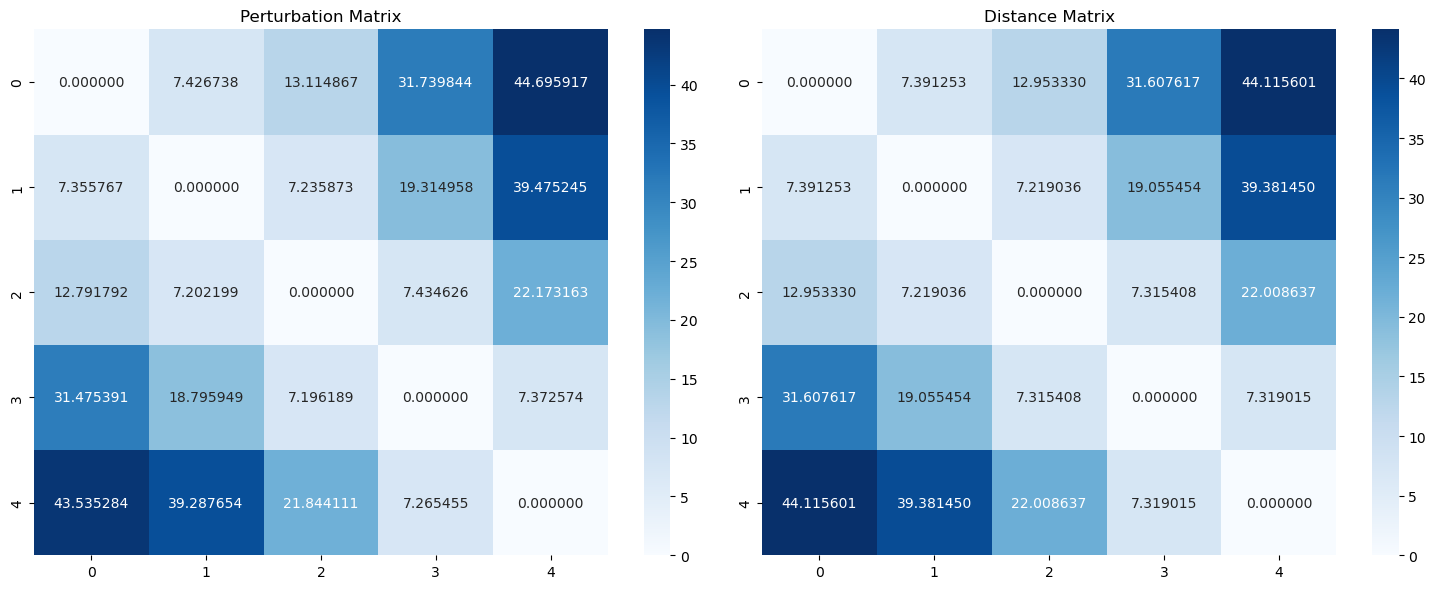

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6))
sns.heatmap(pertr_mtrx[:5, :5], annot=True, cmap='Blues', fmt='f', ax=axs[0])
axs[0].set_title('Perturbation Matrix')

sns.heatmap(dist_mtrx[:5, :5], annot=True, cmap='Blues', fmt='f', ax=axs[1])
axs[1].set_title('Distance Matrix')

plt.tight_layout()
plt.show()

In [12]:
def cayley_menger(dist_mtrx):
  n = dist_mtrx.shape[0]

  # Create a matrix of appropriate size, initialized with zeros
  cm_matrix = np.zeros((n+1, n+1))

  # Fill the main part of the matrix with distances
  cm_matrix[1:, 1:] = dist_mtrx

  # Fill the first row and first column with ones, excluding the first element
  cm_matrix[0, 1:] = 1
  cm_matrix[1:, 0] = 1

  return cm_matrix

In [13]:
# Create the Cayley-Menger matrix
cm_mtrx = cayley_menger(pertr_mtrx)

In [14]:
def write_cayley_menger(matrix, filename):
    with open(filename, 'w') as f:
        f.write("% Cayley-Menger matrix\n")
        f.write("% non-symmetric, contains up/low bounds\n")
        f.write("%\n")
        f.write("function B = cm_mtrx()\n")
        f.write(" \n")
        f.write("B = [\n")
        for row in matrix:
            f.write(" ".join(map(str, row)) + ";\n")
        f.write("];\n")
        f.write("%\n")
        f.write("% end of function cm_mtrx\n")

In [ ]:
# Write the matrix to a file
write_cayley_menger(cm_mtrx, '../data/cm_mtrx_1anp_state2.m')

After running the matlab code, we export the matrix variable as a csv file using: csvwrite('new_cm_mtrx.csv', ans)

In [ ]:
# Open the new csv file
with open('../data/new_cm_mtrx_1anp_state2.csv', 'r') as f:
    reader = csv.reader(f)

    # Read every row in the csv file
    data = list(reader)

    # Convert the data to float numbers, because csv reader returns list of strings
    data = [[float(num) for num in row] for row in data]

# Convert the data to a numpy array
new_cm_mtrx = np.array(data)

In [17]:
# Compute the rank of the new Cayley-Menger matrix (5 means embeddable in 3D space)
rank = np.linalg.matrix_rank(new_cm_mtrx)

print('The rank of the matrix is', rank)

The rank of the matrix is 29


In [18]:
# Convert the Cayley-Menger matrix back to the distance matrix
new_dist_mtrx = new_cm_mtrx[1:, 1:]

In [19]:
# Convert the Distance matrix to coordinates
from sklearn.manifold import MDS

# Create an MDS object for n-dimensional scaling (n=3 for 3D coordinates)
mds = MDS(n_components=3, dissimilarity='precomputed', random_state=1)

# Fit the MDS object to the distance matrix and retrieve the coordinates
coords = mds.fit_transform(new_dist_mtrx)

In [20]:
# Calculate c-RMSD between the two structures
from Bio.SVDSuperimposer import SVDSuperimposer

def list_to_numpy_arrays(coords):
    """
    Convert a list of [x, y, z] coordinates to numpy arrays.
    """
    return np.array(coords)

def calc_rmsd_and_align(atoms1, atoms2):
    """
    Align and calculate the RMSD between two sets of coordinates.
    """
    assert len(atoms1) == len(atoms2)

    # Create a SVDSuperimposer object
    svd_super_imposer = SVDSuperimposer()

    # Apply the superimposition on the coordinates
    svd_super_imposer.set(atoms1, atoms2)

    # Compute the rotation and translation matrices
    svd_super_imposer.run()

    # Get rotation and translation matrices
    rot, tran = svd_super_imposer.get_rotran()

    # Align the second coordinates to the first ones
    atoms2 = np.dot(atoms2, rot) + tran

    # Calculate the RMSD
    rmsd = svd_super_imposer.get_rms()

    # Return the aligned coords2 and the RMSD
    return atoms2, rmsd

In [21]:
# Convert lists of coordinates to numpy arrays
atoms1 = list_to_numpy_arrays(coords) # 'coords' are from MDS
atoms2 = list_to_numpy_arrays(atoms) # 'atoms' are from the PDB file

aligned_coords2, rmsd = calc_rmsd_and_align(atoms1, atoms2)

In [22]:
print('The c-RMSD between the two structures is:', rmsd, 'Angstrom')

The c-RMSD between the two structures is: 41.37902340372046 Angstrom
